In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)

sys.path.insert(2,synth_ar_path+"src/")
sys.path.insert(3,synth_ar_path+"plotting/")

import data_config
###############################################################################
import flightcampaign
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")


In [2]:
#-----------------------------------------------------------------------------#        
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""    
def simplified_run_grid_main(config_file_path=synth_ar_path,
         campaign="HALO_AC3",hmp_plotting_desired=True,
         hmc_plotting_desired=False,
         plot_data=True,ar_of_day="AR_entire_1",
         flight=["RF05"],
         era_is_desired=True,carra_is_desired=False,
         icon_is_desired=False,synthetic_flight=False,
         ######################################################################
         # USEFUL values
         upsample_time="20min", # ---> very important for computational ressources
         ######################################################################
         track_type="internal",
         merge_all_legs=False,
         pick_legs=["inflow","internal","outflow"]):
    
    # real campaigns
    years={"RF02":"2022","RF03":"2022","RF04":"2022","RF05":"2022",
               "RF06":"2022","RF07":"2022","RF08":"2022","RF16":"2022"}
    months={"RF02":"03","RF03":"03","RF04":"03","RF05":"03",
               "RF06":"03","RF07":"03","RF08":"03","RF16":"04"}
    days={"RF02":"12","RF03":"13","RF04":"14","RF05":"15",
               "RF06":"16","RF07":"20","RF08":"21","RF16":"10"}
    hours_time=['00:00', '01:00', '02:00','03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00','09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00','15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00','21:00', '22:00', '23:00',]
    analysing_campaign=True
    
    airborne_data_importer_path=config_file_path+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/"
    print("Analyse given flight: ",flight[0])
    config_file=data_config.load_config_file(config_file_path,
                                             "data_config_file")
    
    date=years[flight[0]]+months[flight[0]]+days[flight[0]]
    
    plot_cfad=False
    #-------------------------------------------------------------------------#
    # Boolean Definition of Task to do in Analysis
    # Define the hydrometeor parameters to analyze and to plot         
    include_retrieval=False
    do_orographic_masking=False
    do_moisture_budget=False
    #-------------------------------------------------------------------------#
    if flight[0]=="RF12":
        do_orographic_masking=True
    print("Analyse AR:",ar_of_day)
    
    if plot_data:
        if not any("plotting" in path for path in sys.path):
            # add plot_path to import things
            current_path=os.getcwd()
            plot_path=current_path+"/plotting/"
            print(sys.path)
        # Plot modules
        import matplotlib.pyplot as plt
        try:
            from typhon.plots import styles
        except:
            print("Typhon module cannot be imported")
        
        from flightmapping import FlightMaps
        import interpdata_plotting 

    else:
        print("No data is plotted.")
        
    ac3=flightcampaign.HALO_AC3(is_flight_campaign=True,
                    major_path=config_file["Data_Paths"]["campaign_path"],
                    aircraft="HALO",instruments=["radar","dropsondes","sonde"])
    cmpgn_cls=ac3
    working_path=os.getcwd()+"/../../../Work/"
    airborne_data_importer_path=working_path+"/GIT_Repository/"+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/"
    measurement_processing_path=os.getcwd()+\
                "/../../hamp_processing_python/src/"
    
    sys.path.insert(4,measurement_processing_path)
    import campaign_time
    import config_handler
    import measurement_instruments_ql as Instruments
                
    cfg=config_handler.Configuration(
                    major_path=airborne_data_importer_path)
                
    processing_cfg_name="unified_grid_cfg"    
    cfg.add_entries_to_config_object(processing_cfg_name,
                            {"t1":date,"t2":date,
                             "date":date,"flight_date_used":date})
    processing_config_file=cfg.load_config_file(processing_cfg_name)
    processing_config_file["Input"]["data_path"]=\
                    processing_config_file["Input"]["campaign_path"]+\
                        "Flight_Data/"
    processing_config_file["Input"]["device_data_path"]=\
                    processing_config_file["Input"]["data_path"]+campaign+"/"
                
    prcs_cfg_dict=dict(processing_config_file["Input"])    
    prcs_cfg_dict["date"]=date
    Campaign_Time_cls=campaign_time.Campaign_Time(
                    campaign,date)
    prcs_cfg_dict["Flight_Dates_used"] =\
                    Campaign_Time_cls.specify_dates_to_use(prcs_cfg_dict)
    
    HALO_cls=Instruments.HALO_Devices(prcs_cfg_dict)
    Bahamas_cls=Instruments.BAHAMAS(HALO_cls)
    Bahamas_cls.open_bahamas_data(raw_or_processed="processed")
    bahamas_ds=Bahamas_cls.bahamas_ds[["alt","lat","lon","speed_gnd"]]
    bahamas_ds=bahamas_ds.rename_vars({"lat":"latitude","lon":"longitude",
                                    "speed_gnd":"groundspeed"})
    halo_df=bahamas_ds.to_dataframe()
    
    halo_df["Hour"]=pd.DatetimeIndex(halo_df.index).hour
    halo_df["Minutes"]=pd.DatetimeIndex(halo_df.index).minute
    halo_df["Minutesofday"]=halo_df["Hour"]*60+halo_df["Minutes"]
    
    if "distance" in halo_df.columns:
        del halo_df["distance"]
    
    #Define the file names of hydrometeor data and paths
    flight_name=flight[0]
    
    if ar_of_day:
        interpolated_hmp_file=flight_name+"_"+ar_of_day+\
                                "_HMP_ERA_HALO_"+date+".csv"
    else:
        interpolated_hmp_file="HMP_ERA_HALO_"+date+".csv"
    
    hydrometeor_lvls_path=cmpgn_cls.campaign_path+"/data/ERA-5/"
    hydrometeor_lvls_file="hydrometeors_pressure_levels_"+date+".nc"
        
    if synthetic_flight:
        interpolated_hmp_file="Synthetic_"+interpolated_hmp_file
        # Until now ERA5 is not desired
    if ar_of_day is not None:
        interpolated_iwc_file=flight_name+"_"+ar_of_day+"_IWC_"+date+".csv"        
    else:
        interpolated_iwc_file=flight_name+"_IWC_"+date+".csv"
    if synthetic_flight:
        interpolated_iwc_file="Synthetic_"+interpolated_iwc_file
    if icon_is_desired:
        if synthetic_icon:
            hydrometeor_lvls_path=hydrometeor_lvls_path+"Latitude_"+\
            str(synthetic_icon_lat)+"/"
       
    else:
        print("This none dataset of the flight campaign.")
        print("No airborne datasets will be integrated.")
    #-------------------------------------------------------------------------#
    #%% ERA5 class & ERA5 on HALO Class
    era5=ERA5(for_flight_campaign=True,campaign=campaign,research_flights=None,
                     era_path=hydrometeor_lvls_path)

    ERA5_on_HALO=Grid_on_HALO.ERA_on_HALO(
                                halo_df,hydrometeor_lvls_path,
                                hydrometeor_lvls_file,interpolated_iwc_file,
                                analysing_campaign,campaign,
                                config_file["Data_Paths"]["campaign_path"],
                                flight,date,config_file,ar_of_day=ar_of_day,
                                synthetic_flight=synthetic_flight,
                                do_instantaneous=False)
    #%% CARRA class & CARRA on HALO class
    if carra_is_desired:
        interpolated_carra_file=""
        carra_lvls_path=cmpgn_cls.campaign_path+"/data/CARRA/"
    
        carra=CARRA(for_flight_campaign=True,
                    campaign=campaign,research_flights=None,
                    carra_path=carra_lvls_path) 
        
        CARRA_on_HALO=Grid_on_HALO.CARRA_on_HALO(
                                halo_df,carra_lvls_path,
                                analysing_campaign,campaign,
                                config_file["Data_Paths"]["campaign_path"],
                                flight,date,config_file,ar_of_day=ar_of_day,
                                upsample_time=upsample_time,
                                synthetic_flight=synthetic_flight,
                                do_instantaneous=False)
   
    # Measurement instruments if needed
    HAMP_cls=Instruments.HAMP(HALO_cls)
    HAMP_cls.open_processed_hamp_data(open_calibrated=False,
                            newest_version=True)
    mwr=HAMP_cls.processed_hamp_ds
    mwr=mwr.rename({"TB":"T_b"})
    RADAR_cls=Instruments.RADAR(HALO_cls)
    RADAR_cls.open_processed_radar_data(reflectivity_is_calibrated=False)
            
    radar_ds=RADAR_cls.processed_radar_ds
    radar={}
    radar["Reflectivity"]=pd.DataFrame(data=np.array(
                                    radar_ds["dBZg"].values[:]),
                                       index=pd.DatetimeIndex(
                                           np.array(radar_ds.time[:])),
                                       columns=np.array(radar_ds["height"][:]))
    radar["LDR"]=pd.DataFrame(data=np.array(radar_ds["LDRg"].values[:]),
                            index=pd.DatetimeIndex(
                            np.array(radar_ds.time[:])),
                            columns=np.array(radar_ds["height"][:]))
    radar["Position"]=halo_df.copy()
    del radar_ds
    # Cut dataset to AR core cross-section
    if ar_of_day:
            #radar
            halo_df,radar,ar_of_day=ERA5_on_HALO.cut_halo_to_AR_crossing(
                                                ar_of_day, flight[0], 
                                                halo_df,radar,
                                                device="radar")
            #radiometer
            halo_df,mwr,ar_of_day=ERA5_on_HALO.cut_halo_to_AR_crossing(
                                                ar_of_day, flight[0], 
                                                halo_df,mwr,
                                                device="radiometer")
        
            # Update halo_df in ERA5_on_HALO class with cutted dataset
            ERA5_on_HALO.update_halo_df(halo_df,change_last_index=True)
            if carra_is_desired:
                CARRA_on_HALO.update_halo_df(halo_df,change_last_index=True)
            if cmpgn_cls.name=="HALO_AC3":
                pos_path=hydrometeor_lvls_path+"/../BAHAMAS/"
            else:
                pos_path=cmpgn_cls.campaign_data_path
            radar["Position"].to_csv(path_or_buf=pos_path+\
                             "HALO_Aircraft_"+flight[0]+".csv")
        
        # Load Dropsonde datasets
            Sondes_cls=Instruments.Dropsondes(HALO_cls)
            Sondes_cls.calc_integral_variables(integral_var_list=["IWV","IVT"])
            Dropsondes=Sondes_cls.sonde_dict

                #Dropsondes={}
    else:
        Dropsondes={}
        radar={}
        mwr={}
    
    last_index=len(halo_df.index)
    lat_changed=False
    
    #%% Gridded data (Simulations and Reanalysis)
    #hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
    #ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
    #%% Processing, Interpolation onto Flight Path
    # If interpolated data does not exist, load ERA-5 Dataset
    
    # Create HALO interpolated total column data  if not existent, 
    # if HMPs already interpolated onto HALO for given flight, load csv-file.
    if hmp_plotting_desired:
        if not os.path.exists(hydrometeor_lvls_path):
                os.makedirs(hydrometeor_lvls_path)
        print("Path to open: ", hydrometeor_lvls_path)
        print("open hydrometeor_levels")
        
        #----------------- ERA-5 ---------------------------------------------#
        ERA5_on_HALO.update_interpolated_hmp_file(interpolated_hmp_file)
        halo_era5=ERA5_on_HALO.load_hmp(cmpgn_cls)
        halo_era5=halo_era5.groupby(level=0).first()#drop_duplicates(keep="first")
        halo_df=halo_df.groupby(level=0).first()
        if "Interp_IVT" in halo_era5.columns:
            if not "groundspeed" in halo_df.columns:
                if radar!={}:
                    halo_df.index=pd.DatetimeIndex(halo_df.index)
                    halo_df["groundspeed"]=radar["Position"]["groundspeed"].\
                                            loc[halo_df.index]
        halo_era5=cmpgn_cls.calc_distance_to_IVT_max(
                        halo_df,
                        halo_era5)
        #---------------------------------------------------------------------#
        #if carra_is_desired:
        #    CARRA_on_HALO.load_or_calc_interpolated_hmp_data()
        #    #update_interpolated_hmp_file(self,interpolated_hmp_file):
        #    high_res_hmp=CARRA_on_HALO.halo_carra_hmp.copy()
        #----------------- ICON ----------------------------------------------#
        #if icon_is_desired:
        #    ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
        #    halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()
            #high_res_hmp=halo_icon_hmp.copy()
       #----------------------------------------------------------------------# 
    cmpgn_cls.flight=flight
    return halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes

In [3]:
ar_of_day="AR_entire_1"
flight=["RF05"]
halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
    simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
#halo_era5
flight=cmpgn_cls.flight

Analyse given flight:  RF05
C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini.ini  already exists
Analyse AR: AR_entire_1
Overall directory of campaign is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3
Entries:  dict_keys(['t1', 't2', 'date', 'flight_date_used']) have added to or changed in the config file
C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../../../Work//GIT_Repository/hamp_processing_py/hamp_processing_python//unified_grid_cfg.ini
RF00    20220225
RF01    20220311
RF02    20220312
RF03    20220313
RF04    20220314
RF05    20220315
RF06    20220316
RF07    20220320
RF08    20220321
RF09    20220328
RF10    20220329
RF11    20220330
RF12    20220401
RF13    20220404
RF14    20220407
RF15    

In [4]:
import interpdata_plotting
from flightmapping import FlightMaps
        
#-------------- Plot Path Specifications ---------------------------------#
major_plot_path=cmpgn_cls.campaign_path+"/plots/"
if not os.path.exists(major_plot_path):
    os.mkdir(major_plot_path)
plot_path=major_plot_path+flight[0]+"/"
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

#Check if plot path exists, if not create it.
if ar_of_day!=None:
        plot_path=plot_path+ar_of_day+"/"
        if not os.path.exists(plot_path):
            os.mkdir(plot_path)
    #-------------------------------------------------------------------------#
ERA_HALO_Plotting   = interpdata_plotting.ERA_HALO_Plotting(
                                        flight,ar_of_day=ar_of_day,
                                        plot_path=plot_path,
                                        synthetic_campaign=False)    
#CARRA_HALO_Plotting = interpdata_plotting.CARRA_HALO_Plotting(
#                                        plot_path=plot_path,
#                                        flight=flight,ar_of_day=ar_of_day,
#                                        synthetic_campaign=synthetic_flight)
# Mainly for ICON Plotting, but IVT cross-section plotter using ERA-5
# and/or ICON is included in ICON_HALO_Plotting
#if icon_is_desired:
#    icon_plot_path=plot_path+"ICON_2km/"
#    if not os.path.exists(icon_plot_path):
#        os.mkdir(icon_plot_path)
#    else:
#        icon_plot_path=plot_path # If ICON is not included, 
                                 # plot_path remains due to IVT-plot                        
#    ICON_HALO_Plotting  = interpdata_plotting.ICON_HALO_Plotting(cmpgn_cls,
#                                plot_path=icon_plot_path,
#                                flight=flight,ar_of_day=ar_of_day,
#                                synthetic_campaign=False)
    
#-------------------------------------------------------------------------#
#Load Flight map class
Flightmap=FlightMaps(cmpgn_cls.major_path,cmpgn_cls.campaign_path,
                         cmpgn_cls.aircraft,cmpgn_cls.instruments,
                         cmpgn_cls.interested_flights,plot_path=plot_path,
                         flight=flight[0],ar_of_day=ar_of_day,
                         synthetic_campaign=False,
                         synthetic_icon_lat=0,
                         synthetic_icon_lon=0,
                         track_type="internal",pick_legs="all",
                         track_dict=None)

set_font=ERA_HALO_Plotting.specify_plotting()
style_name="typhon"
###################################################################
## Moisture Budget visualization
#icon_plot_path=plot_path+"ICON_2km/"
#ERA_HALO_Plotting.plot_radar_era5_time_series(
#                        radar,halo_era5,Dropsondes,flight,
#                        plot_path,save_figure=True)
#ICON_HALO_Plotting.plot_IVT_icon_era5_sondes(halo_era5,
#                        Dropsondes,last_index,date,with_ICON=False,
#                        with_CARRA=carra_is_desired)
#ICON_HALO_Plotting.plot_IVT_icon_era5_sondes(halo_era5,
#            Dropsondes,last_index,date,with_ICON=True,
#            with_CARRA=carra_is_desired)
###################################################################            


IVT conv. mapped
Evaporation mapped
Total precipitation mapped
IWV Tendency mapped
Hour of the day: 13
Meridional-Zonal ratio:  -3.447591868558392


KeyError: 'Lat'

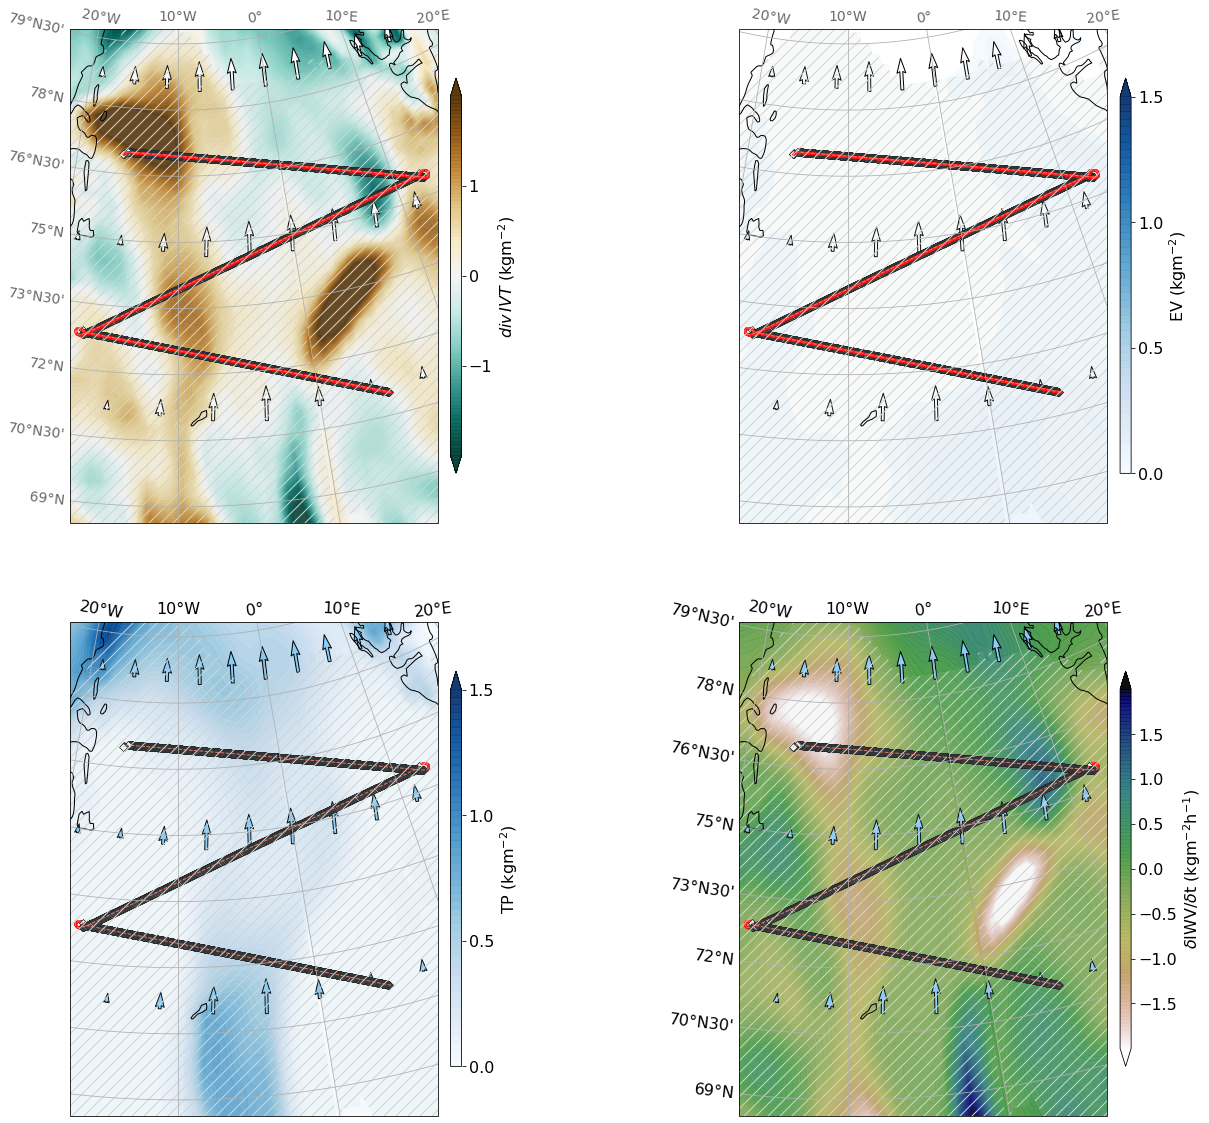

In [5]:
# Map the AR flight intersection
last_hour=pd.DatetimeIndex(halo_df.index).hour[-1]#
Flightmap.halo_dict={flight[0]:halo_df}

Flightmap.plot_AR_moisture_components_map(ERA5_on_HALO,radar,Dropsondes,cmpgn_cls)
if not flight[0].endswith("instantan"):
    Flightmap.plot_moisture_budget(ERA5_on_HALO,radar,
    Dropsondes,cmpgn_cls)
try:    
    ICON_HALO_Plotting.plot_hmp_icon_era5_sondes(radar,
        halo_icon_hmp,halo_era5,Dropsondes,last_index,flight,ar_of_day,
        synthetic_icon_lat=synthetic_icon_lat)
except:
    pass
#AR_IWV_section_combined_mapping(radar,Dropsondes,cmpgn_cls,
#                                                last_hour,
#                                                opt_plot_path=plot_path)
#Flightmap.plot_flight_map_Hydrometeorpaths_AR_crossing(radar,
#                                        Dropsondes,cmpgn_cls,last_hour,
#                                        with_ICON=True)
#Flightmap.plot_flight_map_Hydrometeorpaths_AR_crossing(radar,
#                                        Dropsondes,cmpgn_cls,last_hour,
#                                        with_ICON=False)
    #%% Return of data
halo_era5.name="ERA5"
#if carra_is_desired or icon_is_desired:
#    high_res_hmp=high_res_hmp.groupby(level=0).first()
#try:
#    halo_era5["highres_Interp_IWV"]=high_res_hmp["Interp_IWV_clc"].values
#except:
#    halo_era5["highres_Interp_IWV"]=high_res_hmp["Interp_IWV"]
#    halo_era5["highres_Interp_IVT"]=high_res_hmp["Interp_IVT"].values
#if carra_is_desired and not icon_is_desired:
#    halo_era5.name="CARRA"
#elif icon_is_desired:
#    halo_era5.name="ICON"
#        if "aircraft_dict" in locals().keys():
#            return halo_era5,radar,aircraft_dict
#        else:
#            return halo_era5,radar,{}
#else:
#        halo_grid_hmc=halo_era5_hmc.copy()
#        halo_grid_hmc["name"]="ERA5"
#        if carra_is_desired and not icon_is_desired:
#            halo_grid_hmc=halo_carra_hmc.copy()
#            halo_grid_hmc["name"]="CARRA"
        #elif icon_is_desired:
        #    halo_era5_hmc["name"]="ICON"
#        if "aircraft_dict" in locals().keys():
#            return halo_grid_hmc,radar,aircraft_dict        
#        else:
#            return halo_grid_hmc,radar,{}

In [ ]:
hmc_plotting_desired=False
if hmc_plotting_desired:
    #if synthetic_icon:
            #if synthetic_icon_lat!=0:
    #     hydrometeor_lvls_path=hydrometeor_lvls_path+"Latitude_"+\
           # str(synthetic_icon_lat)+"/"
    #----------------------------------------------------------------------#
    # ERA5 
    if era_is_desired:
           halo_era5_hmc=ERA5_on_HALO.load_hwc()
       #----------------------------------------------------------------------#
       # CARRA
    if not carra_is_desired:
           pass
    else:
        CARRA_on_HALO.load_or_calc_interpolated_hmc_data()
        halo_carra_hmc=CARRA_on_HALO.carra_halo_hmc
    #
    # ICON                                                               
    if not icon_is_desired:
            pass
    else:
        #Get vertical profiles of moisture/ hydrometeors
        halo_icon_hmc=ICON_on_HALO.load_hwc(with_hydrometeors=False)
    #----------------------------------------------------------------------#    
    # Retrieval
    if flight==["RF10"]:
        if include_retrieval:
            retrieval_dict=cmpgn_cls.load_radiometer_retrieval(
                                       campaign,
                                       variables=["T","rho_v"],
                                       calculate_spec_hum=True,
                                       sonde_p=Upsampled_Dropsondes["Pres"])
            retrieval_dict=cmpgn_cls.vertical_integral_retrieval(
                                        retrieval_dict,Upsampled_Dropsondes)
                
    #%%
    """
        Plotting of datasets from HALO_ERA_Plotting class   
    """
    levels=np.linspace(0,50,50)
    

"""
old stuff not needed
###########################################################################
        ## HMC visualization
        if hmc_plotting_desired:
            # Sometimes typhon works, sometimes not, this is why 
            # try except commands are used.
            with plt.style.context(styles(style_name)):
                print("Plots created with Typhon")
                #try:
                #    ERA_HALO_Plotting.plot_radar_era5_combined_hwc(radar,
                #                                halo_era5_hmc,date,
                #                                'temperature',
                #                                save_figure=True)
        
                #except:
                    #    pass
                #try:
                    #    ICON_HALO_Plotting.plot_radar_icon_hwc(
                    #                    radar,halo_icon_hmc,
                    #                    "temperature",save_figure=True)
                #except:
                    #pass
                #
                if not synthetic_flight:
                    try:
                        cmpgn_cls.plot_hamp_brightness_temperatures(mwr["T_b"],
                                flight,date,halo_era5_hmc["IWC"].index[0],
                                halo_era5_hmc["IWC"].index[-1],
                                ar_of_day=ar_of_day,
                                plot_path=plot_path)
                    except:
                        pass
                
                    try:
                        cmpgn_cls.plot_radar_AR_quicklook(radar,ar_of_day,
                                                   flight[0],plot_path)
                    except:
                        pass
                
                try:
                    
                    cmpgn_cls.plot_AR_sonde_thermodynamics(Upsampled_Dropsondes,
                                    radar,date,flight[0],
                                    os.getcwd()+"/"+flight[0]+"/",
                                    Upsampled_Dropsondes["AirT"].index[0],
                                    Upsampled_Dropsondes["AirT"].index[-1],
                                    plot_path=plot_path,save_figure=True,
                                    low_level=True,ar_of_day=ar_of_day)
                except:
                    print("No dropsonde plot created")
                if track_type=="internal":
                    try:
                        ERA_HALO_Plotting.internal_leg_representativeness(cmpgn_cls,
                                                                      ERA5_on_HALO,
                                                                      flight[0],
                                                                      halo_df,
                                                                      halo_era5_hmc)
                    except:
                        pass
                    if icon_is_desired:
                        try:
                            ICON_HALO_Plotting.mean_internal_leg_representativeness(
                                        cmpgn_cls,ICON,ICON_on_HALO,
                                        flight[0],halo_df,halo_icon_hmc)
                        except:
                            pass
                        try:    
                            Flightmap.plot_ar_section_internal_leg_ICON(cmpgn_cls)
                        except:
                            pass
                        #try:
                        #    ICON_HALO_Plotting.internal_leg_representativeness(
                        #                                cmpgn_cls,ICON,ICON_on_HALO,
                        #                                flight[0],halo_df,
                        #                                halo_icon_hmc)
                        #except:
                        #    pass
                        #        sys.exit()
                    
                    # can also be done when having synthetic observations
                    #Low level plot
                try:
                    ERA_HALO_Plotting.two_H_plot_radar_era5_combined_hwc(
                                ERA5_on_HALO,
                                radar,halo_era5_hmc,date,
                                'temperature',
                                halo_era5_hmc["IWC"].index[0],
                                halo_era5_hmc["IWC"].index[-1],
                                save_figure=True,
                                do_masking=do_orographic_masking,
                                low_level=True)
                except:
                    pass
                try:
                    ERA_HALO_Plotting.two_H_plot_radar_era5_combined_hwc(
                                        ERA5_on_HALO,
                                        radar,halo_era5_hmc,
                                        date,'temperature',
                                        halo_era5_hmc["IWC"].index[0],
                                        halo_era5_hmc["IWC"].index[-1],
                                        save_figure=True,low_level=False)
                except:
                    pass
            
                # All levels
                try: 
                    ERA_HALO_Plotting.plot_HALO_AR_ERA_thermodynamics(
                                    ERA5_on_HALO,radar,halo_era5_hmc,date,
                                    halo_era5_hmc["IWC"].index[0],
                                    halo_era5_hmc["IWC"].index[-1],
                                    do_masking=do_orographic_masking,
                                    save_figure=True,low_level=False)
                except:
                    pass
                # Low level
                try:
                    ERA_HALO_Plotting.plot_HALO_AR_ERA_thermodynamics(
                                    ERA5_on_HALO,
                                    radar,halo_era5_hmc,date,
                                    halo_era5_hmc["IWC"].index[0],
                                    halo_era5_hmc["IWC"].index[-1],
                                    do_masking=do_orographic_masking,
                                    low_level=True)
                    if carra_is_desired:
                        CARRA_HALO_Plotting.plot_specific_humidity_profile(
                            halo_carra_hmc,halo_df,Dropsondes,radar,date,
                            halo_carra_hmc["u"].index[0],
                            halo_carra_hmc["u"].index[-1],
                            do_masking=do_orographic_masking,
                            low_level=True,AR_sector="all")
                except:
                    pass
            
                if icon_is_desired:                    
                    if ar_of_day:
                        print("Load calc ERA z total column interpolated data")
                        halo_era5=pd.read_csv(hydrometeor_lvls_path+\
                                          interpolated_hmp_file)
                        halo_era5.index=pd.DatetimeIndex(halo_era5.iloc[:,0])
                    
                        ICON_HALO_Plotting.plot_HALO_AR_ICON_thermodynamics(
                                            halo_icon_hmc,halo_era5,
                                            Dropsondes,radar,date,
                                            os.getcwd()+"/"+flight[0]+"/",
                                            halo_icon_hmc["u"].index[0],
                                            halo_icon_hmc["u"].index[-1],
                                            hydrometeor_icon_path,
                                            with_ivt=True,do_masking=False,
                                            save_figure=True, low_level=True)
                        try:
                            ICON_HALO_Plotting.plot_AR_q_lat(halo_icon_hmc,halo_df,
                                            Dropsondes,radar,date,
                                            os.getcwd()+"/"+flight[0]+"/",
                                            halo_icon_hmc["u"].index[0],
                                            halo_icon_hmc["u"].index[-1],
                                            hydrometeor_icon_path,
                                            with_ivt=True,do_masking=False,
                                            save_figure=True, low_level=True)
                        except:
                            pass
                        if flight[0]=="RF10":
                            if include_retrieval:
                                cmpgn_cls.retrieval_humidity_plotting(
                                    halo_icon_hmc,retrieval_dict,Dropsondes,
                                    Upsampled_Dropsondes,date,
                                    flight[0],os.getcwd()+"/"+\
                                        flight[0]+"/",
                                        halo_icon_hmc["u"].index[0],
                                        halo_icon_hmc["u"].index[-1],
                                    hydrometeor_icon_path,
                                    plot_path=plot_path,
                                    with_ivt=True,
                                    do_masking=False,
                                    save_figure=True,
                                    low_level=True, 
                                    ar_of_day=ar_of_day)
"""